In [14]:
%load_ext autoreload
%autoreload 2

from models import RNN
from utils import DataManager
import tensorflow as tf
from tensorpack import (TrainConfig, TestDataSpeed, SyncMultiGPUTrainerParameterServer, 
                        SaverRestore, logger)
from tensorpack.callbacks import (ScalarPrinter, ScheduledHyperParamSetter, GPUUtilizationTracker, 
                                  DataParallelInferenceRunner, InferenceRunner)
from utils.validation import ApAndAucScore

image_table_loc = "./data/standard_images.csv"
annot_table_loc = "./data/standard_annotations.csv"
resnet_loc = "./data/resnet_v2_101/resnet_v2_101.ckpt"
logger.set_logger_dir('train_log')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[1010 22:30:40 @logger.py:93] WRN Log directory train_log exists! Please either backup/delete it, or use a new directory.
[1010 22:30:40 @logger.py:95] WRN If you're resuming from a previous run you can choose to keep it.
[1010 22:30:40 @logger.py:96] Select Action: k (keep) / b (backup) / d (delete) / n (new) / q (quit):
d
[1010 22:30:41 @logger.py:74] Argv: /home/fuxiaofeng/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py -f /run/user/1012/jupyter/kernel-5da4e309-fff3-4d1c-9f7e-052803592fe6.json


In [13]:
data_manager = DataManager(image_table_loc, annot_table_loc)
train_data = data_manager.get_train_stream()
val_data = data_manager.get_validation_stream()

In [11]:
tf.reset_default_graph()
ignore_restore = ['process/*', 'logits', 'learning_rate', 'beta1_power', 'beta2_power', 'global_step']
model = RNN(read_time=2, label_num=20, batch_size=32, weight_decay=5e-4)
train_config = TrainConfig(model=model, dataflow=train_data, 
                           callbacks=[
                               ScheduledHyperParamSetter('learning_rate', [(0, 1e-3),(20, 1e-4)]),
                               InferenceRunner(val_data, [ApAndAucScore()]),
                           ], 
                           session_init=SaverRestore(model_path=resnet_loc, ignore=ignore_restore),
                           max_epoch=10, nr_tower=2)

[1010 22:21:06 @inference_runner.py:81] InferenceRunner will eval on an InputSource of size 6


In [12]:
SyncMultiGPUTrainerParameterServer(train_config).train()

[1010 22:21:07 @input_source.py:235] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[1010 22:21:07 @input_source.py:509] Setting up StagingArea for GPU prefetching ...
[1010 22:21:07 @multigpu.py:66] Training a model of 2 towers
[1010 22:21:07 @multigpu.py:87] Building graph for training tower 0...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1010 22:21:11 @regularize.py:95] Add REGULARIZATION_LOSSES of 7 tensors on the total cost.
[1010 22:21:12 @multigpu.py:87] Building graph for training tower 1...
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
[1010 22:21:14 @regularize.py:95] Add REGULARIZATION_LOSSES of 7 tensors on the total cost.
[1010 22:21:15 @model_utils.py:47] Model Parameters: 
name                       shape                  

[1010 22:21:20 @sessinit.py:119] Restoring checkpoint from ./data/resnet_v2_101/resnet_v2_101.ckpt ...
INFO:tensorflow:Restoring parameters from ./data/resnet_v2_101/resnet_v2_101.ckpt
[1010 22:21:21 @base.py:185] Graph Finalized.
[1010 22:21:21 @param.py:144] After epoch 0, learning_rate will change to 0.00100000
[1010 22:21:25 @concurrency.py:36] Starting EnqueueThread QueueInput/input_queue ...
[1010 22:21:25 @input_source.py:474] Pre-filling staging area ...
[1010 22:21:35 @base.py:231] Start Epoch 1 ...


100%|##########|132/132[02:16<00:00, 0.76it/s]

[1010 22:23:52 @base.py:241] Epoch 1 (global_step 132) finished, time:136.81 sec.



  0%|          |0/6[00:00<?,?it/s]

[1010 22:23:56 @input_source.py:203] EnqueueThread QueueInput/input_queue Exited.


RuntimeError: This DataFlow is not reentrant!

In [3]:
train_data.reset_state()
batch = next(train_data.get_data())

In [4]:
batch[2].shape

(32, 20)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

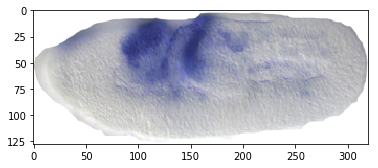

In [67]:
plt.imshow(batch[0][3][0])

In [5]:
for op in tf.get_default_graph().get_operations():
    print (str(op.name))

image
length
label
QueueInput/input_queue
QueueInput/input_queue_enqueue
QueueInput/input_queue_Close
QueueInput/input_queue_Size
QueueInput/queue_size
EMA/QueueInput/queue_size/Initializer/Const
EMA/QueueInput/queue_size
EMA/QueueInput/queue_size/Assign
EMA/QueueInput/queue_size/read
EMA/QueueInput/queue_size_EMA_apply/decay
EMA/QueueInput/queue_size_EMA_apply/EMA/QueueInput/queue_size/zeros
EMA/QueueInput/queue_size/biased
EMA/QueueInput/queue_size/biased/Assign
EMA/QueueInput/queue_size/biased/read
EMA/QueueInput/queue_size/local_step/Initializer/zeros
EMA/QueueInput/queue_size/local_step
EMA/QueueInput/queue_size/local_step/Assign
EMA/QueueInput/queue_size/local_step/read
EMA/QueueInput/queue_size_EMA_apply/EMA/QueueInput/queue_size/sub
EMA/QueueInput/queue_size_EMA_apply/EMA/QueueInput/queue_size/mul
EMA/QueueInput/queue_size_EMA_apply/EMA/QueueInput/queue_size/EMA/QueueInput/queue_size
EMA/QueueInput/queue_size_EMA_apply/EMA/QueueInput/queue_size/AssignAdd/value
EMA/QueueInput/qu

resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean/Initializer/zeros
resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean
resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean/Assign
resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean/read
resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance/Initializer/ones
resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance
resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance/Assign
resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance/read
tower0/resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moments/mean/reduction_indices
tower0/resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moments/mean
tower0/resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moments/StopGradient
tower0/resnet_v2_101/block3/unit_1/bottleneck_v2/conv1/BatchNorm/moments/SquaredDifference
tower0/resnet_

resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/weights/Assign
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/weights/read
tower0/resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/convolution/Shape
tower0/resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/convolution/dilation_rate
tower0/resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/convolution
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/beta/Initializer/zeros
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/beta
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/beta/Assign
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/beta/read
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/gamma/Initializer/ones
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/gamma
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/gamma/Assign
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/gamma/read
resnet_v2_101/block3/unit_17/bottleneck_v2/conv1/BatchNorm/moving_mean/Init

tower0/gradients/AddN_2
tower0/gradients/tower0/process/Sum_4_grad/Shape
tower0/gradients/tower0/process/Sum_4_grad/Size
tower0/gradients/tower0/process/Sum_4_grad/add
tower0/gradients/tower0/process/Sum_4_grad/mod
tower0/gradients/tower0/process/Sum_4_grad/Shape_1
tower0/gradients/tower0/process/Sum_4_grad/range/start
tower0/gradients/tower0/process/Sum_4_grad/range/delta
tower0/gradients/tower0/process/Sum_4_grad/range
tower0/gradients/tower0/process/Sum_4_grad/Fill/value
tower0/gradients/tower0/process/Sum_4_grad/Fill
tower0/gradients/tower0/process/Sum_4_grad/DynamicStitch
tower0/gradients/tower0/process/Sum_4_grad/Maximum/y
tower0/gradients/tower0/process/Sum_4_grad/Maximum
tower0/gradients/tower0/process/Sum_4_grad/floordiv
tower0/gradients/tower0/process/Sum_4_grad/Reshape
tower0/gradients/tower0/process/Sum_4_grad/Tile
tower0/gradients/tower0/process/Reshape_4_grad/Shape
tower0/gradients/tower0/process/Reshape_4_grad/Reshape
tower0/gradients/tower0/process/mul_17_grad/Shape
tow

tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/preact/batchnorm/Rsqrt
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/preact/batchnorm/mul
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/preact/batchnorm/mul_1
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/preact/batchnorm/mul_2
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/preact/batchnorm/sub
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/preact/batchnorm/add_1
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/preact/Relu
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/conv1/convolution/Shape
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/conv1/convolution/dilation_rate
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/conv1/convolution
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/conv1/BatchNorm/moments/mean/reduction_indices
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/conv1/BatchNorm/moments/mean
tower1/resnet_v2_101/block3/unit_3/bottleneck_v2/conv1/BatchNorm/moments/StopGradient
tower1/resnet_v2_101/block3/un

tower1/process/flatten_mem_1
tower1/process/expand_state_1/multiples
tower1/process/expand_state_1
tower1/process/concat_memory_and_state_1/axis
tower1/process/concat_memory_and_state_1
tower1/process/fc_read_1/MatMul
tower1/process/fc_read_1/BiasAdd
tower1/process/recover_time_of_logits_1/shape
tower1/process/recover_time_of_logits_1
tower1/process/SequenceMask_1/Const
tower1/process/SequenceMask_1/Const_1
tower1/process/SequenceMask_1/Const_2
tower1/process/SequenceMask_1/Range
tower1/process/SequenceMask_1/ExpandDims/dim
tower1/process/SequenceMask_1/ExpandDims
tower1/process/SequenceMask_1/Cast
tower1/process/SequenceMask_1/Less
tower1/process/Cast_1
tower1/process/mul_4
tower1/process/Softmax_1
tower1/process/reshape_attention_1/shape
tower1/process/reshape_attention_1
tower1/process/expand_attention_1/multiples
tower1/process/expand_attention_1
tower1/process/mul_5
tower1/process/Reshape_1/shape
tower1/process/Reshape_1
tower1/process/Sum_1/reduction_indices
tower1/process/Sum_1


InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/preact/batchnorm/add_1
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/preact/Relu
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/convolution/Shape
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/convolution/dilation_rate
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/convolution
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/BatchNorm/batchnorm/add/y
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/BatchNorm/batchnorm/add
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/BatchNorm/batchnorm/Rsqrt
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/BatchNorm/batchnorm/mul
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/BatchNorm/batchnorm/mul_1
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/BatchNorm/batchnorm/mul_2
InferenceTower/resnet_v2_101/block3/unit_2/bottleneck_v2/conv1/BatchNorm/bat

140636226121800/RestoreV2_105/shape_and_slices
140636226121800/RestoreV2_105
140636226121800/Assign_105
140636226121800/RestoreV2_106/tensor_names
140636226121800/RestoreV2_106/shape_and_slices
140636226121800/RestoreV2_106
140636226121800/Assign_106
140636226121800/RestoreV2_107/tensor_names
140636226121800/RestoreV2_107/shape_and_slices
140636226121800/RestoreV2_107
140636226121800/Assign_107
140636226121800/RestoreV2_108/tensor_names
140636226121800/RestoreV2_108/shape_and_slices
140636226121800/RestoreV2_108
140636226121800/Assign_108
140636226121800/RestoreV2_109/tensor_names
140636226121800/RestoreV2_109/shape_and_slices
140636226121800/RestoreV2_109
140636226121800/Assign_109
140636226121800/RestoreV2_110/tensor_names
140636226121800/RestoreV2_110/shape_and_slices
140636226121800/RestoreV2_110
140636226121800/Assign_110
140636226121800/RestoreV2_111/tensor_names
140636226121800/RestoreV2_111/shape_and_slices
140636226121800/RestoreV2_111
140636226121800/Assign_111
14063622612180